cuda
Epoch 0 train loss: 0.0294201135059922, val loss: 0.01633672311837817
Epoch 1 train loss: 0.01376229353223483, val loss: 0.013930454569194338
Epoch 2 train loss: 0.01023325862966014, val loss: 0.009516719054302266
Epoch 3 train loss: 0.008310245817183268, val loss: 0.008622284797983694
Epoch 4 train loss: 0.008137862221360032, val loss: 0.008566186436178997
Epoch 5 train loss: 0.008089540209889457, val loss: 0.00854030060220574
Epoch 6 train loss: 0.008037017315574964, val loss: 0.008557288451842835
Epoch 7 train loss: 0.007998173134254405, val loss: 0.008602595890085373
Epoch 8 train loss: 0.007976821488453911, val loss: 0.008650487051987699
Epoch 9 train loss: 0.00795925839692264, val loss: 0.008664377882739464
Epoch 10 train loss: 0.007943882291805546, val loss: 0.008631641035176942
Early stopping
Erro médio absoluto: 3.5373286210409303


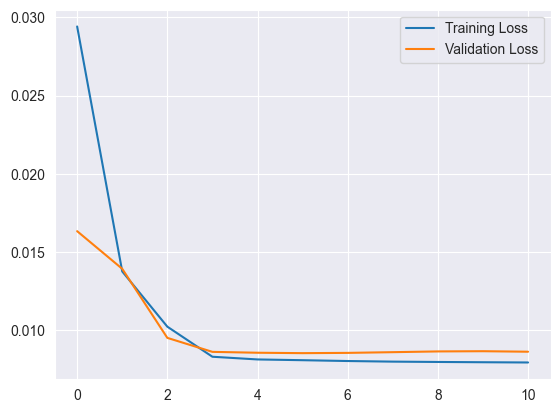

In [2]:
import time

import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

data = pd.read_csv('./dados_tratados/combinado/Piratininga/Piratininga_tratado_combinado.csv', usecols=['PM2.5'])


data = data.dropna()

values = data['PM2.5'].values

# normalizacao dos dados
scaler = MinMaxScaler(feature_range=(-1, 1))
values = values.reshape(-1, 1)
scaled_values = scaler.fit_transform(values)

def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

seq_length = 8
X, y = create_sequences(scaled_values, seq_length)

seed_value = int(time.time())
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

class Attention(nn.Module):
    def __init__(self, input_size=1,hidden_layer_size=100, output_size=1):
        super(Attention, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.attention = nn.Linear(hidden_layer_size, 1)
        
    def forward(self, lstm_output):
        attention_weights = self.attention(lstm_output).squeeze(-1)
        attention_weights = torch.softmax(attention_weights, dim=1)
        context_vector = torch.sum(attention_weights.unsqueeze(-1) * lstm_output, dim=1)
        return context_vector, attention_weights

class LSTMWithAttention(nn.Module):
    def __init__(self, input_size=1,hidden_layer_size=100, output_size=1):
        super(LSTMWithAttention, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm1 = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_layer_size, hidden_layer_size, batch_first=True)
        self.attention = Attention(hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, input_seq):
        lstm_out, _ = self.lstm1(input_seq)
        lstm_out, _ = self.lstm2(lstm_out)
        context_vector, attention_weights = self.attention(lstm_out)
        predictions = self.linear(context_vector)
        return predictions, attention_weights

model = LSTMWithAttention().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, loss_function, optimizer, epochs=150, patience=10):
    train_losses = []
    val_losses = []
    best_val_loss = np.inf
    counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for seq, labels in train_loader:
            seq, labels = seq.to(device), labels.to(device)
            optimizer.zero_grad()
            y_pred, _ = model(seq)
            loss = loss_function(y_pred, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * seq.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for seq, labels in val_loader:
                seq, labels = seq.to(device), labels.to(device)
                y_pred, _ = model(seq)
                loss = loss_function(y_pred, labels)
                val_loss += loss.item() * seq.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch} train loss: {train_loss}, val loss: {val_loss}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1

        if counter >= patience:
            print('Early stopping')
            break
        counter +=1
    return train_losses, val_losses
    
train_losses, val_losses = train_model(model, train_loader, val_loader, loss_function, optimizer)

model.load_state_dict(torch.load('best_model.pth'))

model.eval()
test_predictions = []

with torch.no_grad():
    for seq, labels in test_loader:
        seq, labels = seq.to(device), labels.to(device)
        y_pred, _ = model(seq)
        test_predictions.append(y_pred.cpu().numpy())
        
test_predictions = np.concatenate(test_predictions, axis=0)

test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

mae = np.mean(np.abs(test_predictions - y_test))
mse = np.mean((test_predictions - y_test) ** 2)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

# Plotagem das perdas de treinamento e validação
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()